In [1]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes, NLocal
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.transpiler.passes import RemoveBarriers
import qiskit.quantum_info as qi
import numpy as np
from scipy.optimize import minimize
from scipy.stats import unitary_group
import random

Main part

In [2]:
# Parameterized сircuit
def dec_U(U, rot, ent, reps, phase = False):
    size_v = U[0].size
    num_q = int(np.log2(size_v))
    if(num_q == 1):
        qc_nlocal = NLocal(num_qubits=1, rotation_blocks=rot, entanglement='linear',
                    skip_final_rotation_layer=True, insert_barriers=True, reps=reps)
    else:
        qc_nlocal = NLocal(num_qubits=num_q, rotation_blocks=rot,
                    entanglement_blocks=ent, entanglement='linear',
                    skip_final_rotation_layer=True, insert_barriers=True, reps=reps)

    qc_nlocal = qc_nlocal.decompose()
    if(num_q != 1 and reps != 1):
        for i in range(num_q-1):
            qc_nlocal.data.pop()

    if (phase):# and num_q == 1
        #qc_nlocal.add_layer(phase, front = True)
        params_p = ParameterVector('p', 1)
        qc_nlocal.p(params_p[0], 0)
        qc_nlocal.x(0)
        qc_nlocal.p(params_p[0], 0)
        qc_nlocal.x(0)
    
    return qc_nlocal


# Approximating algorithm
def dec_run(U, rot, ent, reps, param0 = None, phase = None, Nmax = 1):
    qc_nlocal = dec_U(U, rot, ent, reps, phase)
    param_size = qc_nlocal.num_parameters
    print("param_size: ", param_size)

    def loss(param):
        op_param = qi.Operator(qc_nlocal.assign_parameters(param))
        array_param = op_param.data
        norm_ = np.linalg.norm(np.array(U) - np.array(array_param), ord = 'fro')
        return norm_
    
    bounds = [[-np.pi, np.pi] for i in range(param_size)]
    if (param0 == None):
        param0 = np.random.uniform(low=-np.pi, high=np.pi, size=param_size).tolist()
        
    res = minimize(loss, param0, bounds=bounds)
    count = 1
    min_e = loss(res.x)
    min_p = res.x
    while (min_e > 0.000001 and count < Nmax):
        param0 = np.random.uniform(low=-np.pi, high=np.pi, size=param_size).tolist()
        res = minimize(loss, param0, bounds=bounds)
        if(loss(res.x) < min_e):
            min_e = loss(res.x)
            min_p = res.x
        count+=1
    param = np.array(min_p)
    tmp = list(np.around(param,3))
    gp = tmp.pop()
    print("param: ", tmp)
    e = min_e
    print("e: ", e)
    print("gp: ", gp)
    qc_nlocal.assign_parameters(min_p).draw()
    return [qc_nlocal, param, e]

In [3]:
# rotation block:
rot = QuantumCircuit(1)
params = ParameterVector('r', 3)
rot.sx(0)
rot.rz(params[0], 0)
rot.sx(0)
rot.rz(params[1], 0)
rot.sx(0)
rot.rz(params[2], 0)
rot.sx(0)

# entanglement block:
ent = QuantumCircuit(2)
ent.ecr(0, 1)

Samples

In [4]:
num_q = 2
size_v = 2**num_q
U = unitary_group.rvs(size_v)

#qc_U = QuantumCircuit(num_q)
#qc_U.h(0)
#op = qi.Operator(qc_U)
#U = op.data

#print(U)

op = qi.Operator(U)
#print(op.is_unitary())

In [5]:
#basis_gates = ["rx", "ry", "id", "rz", "cx"]
#basis_gates = ["x", "sx", "id", "rz", "ecr"]

param_size:  25
param:  [0.189, 2.064, -2.14, 2.203, -2.937, -1.315, 1.189, -0.938, -2.157, 0.427, -2.926, 3.142, 0.436, 3.054, -2.875, -2.286, 0.13, -0.968, 0.402, 0.022, 2.12, -1.144, -2.242, -1.011]
e:  3.3385086724743226e-08
gp:  -2.547


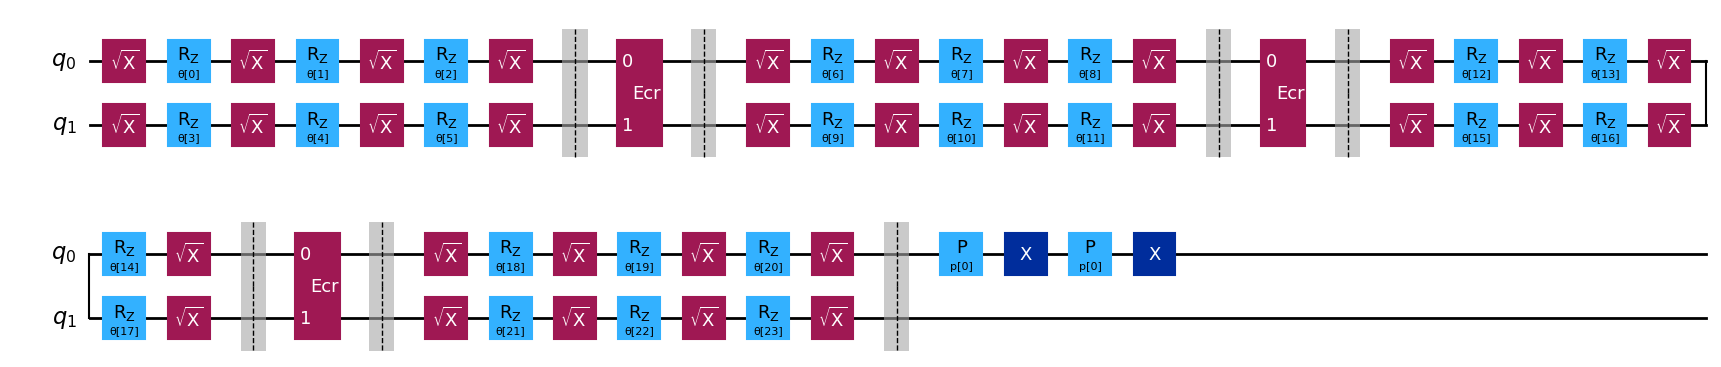

In [7]:
dec_run(U, rot, ent, reps = 4, phase=True, Nmax = 3)[0]#.draw('mpl', style="iqp")#, phase=phase, size_v

param_size:  25
param:  [3.134, 0.233, -2.94, 0.003, 1.694, -3.142, -3.082, 0.744, -1.618, -0.729, 0.449, 1.851, 1.099, 2.079, 0.474, 2.97, 0.498, -1.283, 3.062, 0.874, 3.142, 1.86, -2.245, 3.129]
e:  4.418609044869984e-08
gp:  -1.357


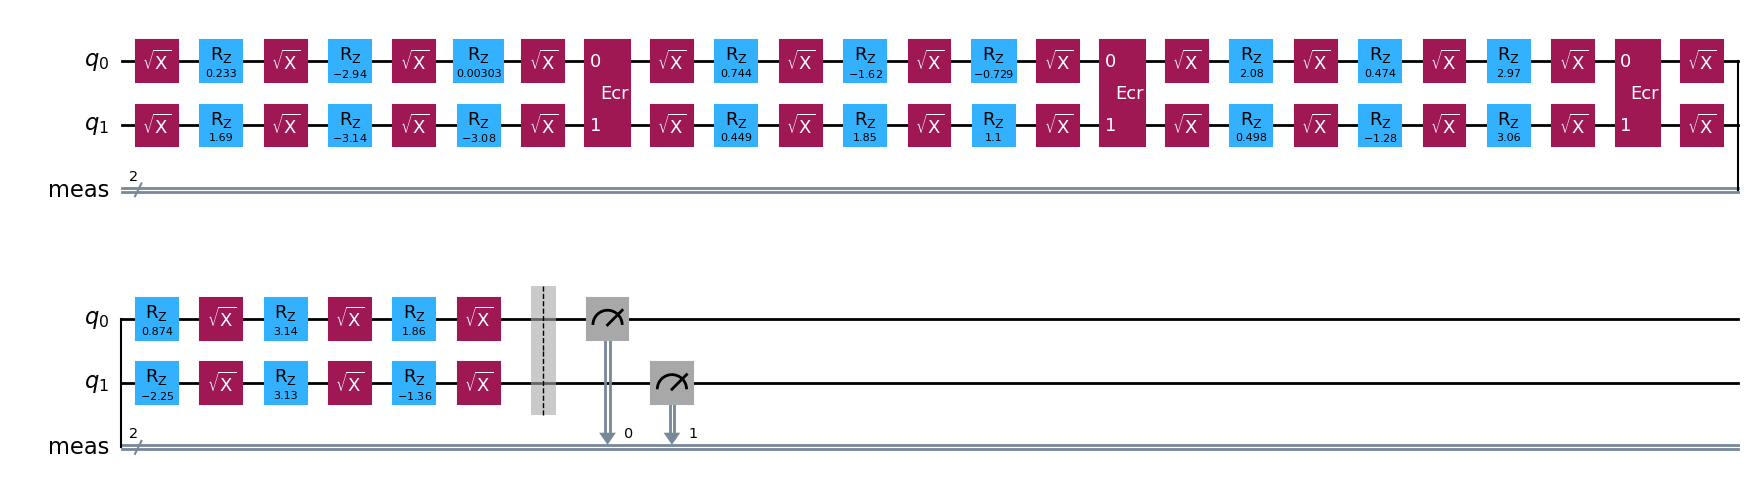

In [8]:
num_q = 2
size_v = 2**num_q
U = unitary_group.rvs(size_v)
dec_tmp = dec_run(U, rot, ent, reps = 4, phase=True, Nmax = 3)#
cir = dec_tmp[0].assign_parameters(dec_tmp[1])
cir.data.pop()
cir.data.pop()
cir.data.pop()
cir.data.pop()
cir = RemoveBarriers()(cir)
cir.measure_all()
cir.draw('mpl', style="iqp")

AerSim

{'11': 1379, '00': 609, '10': 1941, '01': 167}


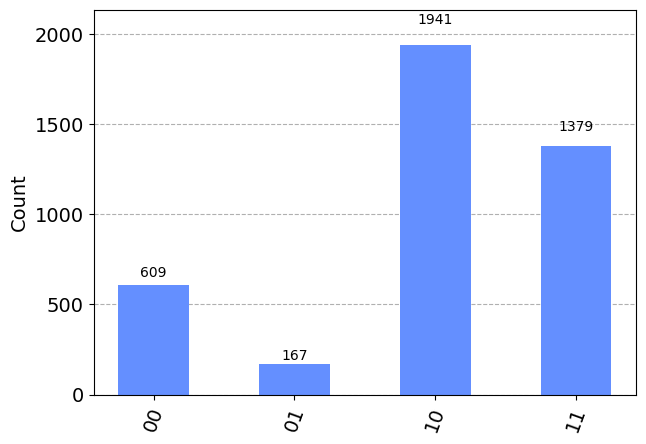

In [9]:
shots = 4096
aer_sim = AerSimulator()
#cir = transpile(cir, aer_sim)
#cir.draw('mpl', style="iqp")
result_sim = aer_sim.run(cir, shots=shots).result()
countsU = result_sim.get_counts(cir)
print(countsU)
plot_histogram(countsU)

IBM quantum

In [ ]:
service = QiskitRuntimeService()
#print(service.backends())
backend = service.get_backend('ibm_sherbrooke')

In [ ]:
transpiled_circuit = transpile(cir, backend)
#transpiled_circuit.draw('mpl', style="iqp")

In [ ]:
job = backend.run(transpiled_circuit, shots=shots)

C:\Users\Александр\AppData\Local\Temp\ipykernel_13284\2345939297.py:1: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_circuit, shots=shots)


{'00': 1662, '10': 1520, '01': 235, '11': 679}


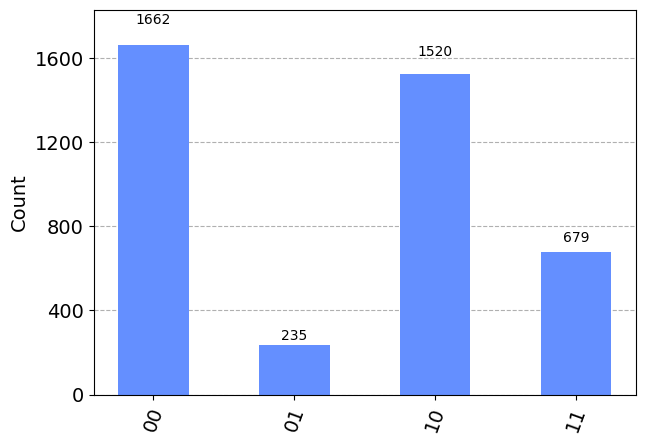

In [ ]:
counts_q = job.result().get_counts()
print(counts_q)
plot_histogram(counts_q)

Experiments

In [11]:
Num_exp = 4
Max_q = 3

res_list = [[], [], []]
for j in range(Max_q):
    for k in range(2**(j+1)+1):
        res_list[j].append([0] * Num_exp)

for i in range (Num_exp):
    print("Num_exp: ", i, '\n')
    for j in range(1, Max_q+1):
        num_q = j
        size_v = 2**num_q
        U = unitary_group.rvs(size_v)
        for k in range(1, size_v+2):#!
            print("Num_q: ", j, " Resp: ", k)
            res_list[j-1][k-1][i]= dec_run(U, rot, ent, reps = k, phase=True, Nmax = 3)[2]


Num_exp:  0 

Num_q:  1  Resp:  3
param_size:  10
param:  [-2.444, -2.537, -2.248, 2.37, -2.192, 3.138, 1.786, -2.114, 1.116]
e:  7.857178918159575e-09
gp:  -3.141
Num_q:  2  Resp:  5
param_size:  31
param:  [-3.1, -2.17, 1.772, -2.362, -2.329, 0.729, 2.712, -2.734, -0.598, -2.873, -2.692, 1.436, -0.39, -0.261, -0.538, 2.887, 1.843, -0.875, -0.194, -2.095, -2.132, -0.42, 0.039, 0.238, 2.791, -2.346, 1.675, -1.259, -1.731, -1.999]
e:  2.499028735115814e-08
gp:  1.754
Num_q:  3  Resp:  9
param_size:  82
param:  [-0.863, -2.189, -1.05, -1.216, 3.142, -0.956, 0.577, -1.086, 1.147, -1.532, -0.539, -1.482, -0.074, -2.157, 3.088, -2.74, 2.655, 3.015, 0.878, -2.311, 0.934, -2.663, 0.687, 1.703, 2.733, 2.982, -2.824, -2.233, 0.858, 1.541, -1.099, 2.143, 1.514, -0.751, -1.958, -2.907, -2.469, 0.756, 0.795, -0.052, 2.838, -3.128, -1.483, -2.935, 0.339, 3.017, 2.499, 0.877, -2.185, -0.751, -0.434, -3.142, -2.996, -0.586, -0.476, 0.045, 2.992, 0.365, 1.953, 1.126, 2.696, 2.429, 0.796, -0.998, -1.79

KeyboardInterrupt: 

In [1707]:
mid_res = [[sum(res_list[j][k])/Num_exp for k in range(2**(j+1))] for j in range(Max_q)]
print(mid_res)

[[0.42606342693223703, 1.2026347531150265e-08], [1.4268576331221052, 0.8947388696029633, 0.14505725492719154, 4.0620143653688265e-08], [3.060116995840844, 2.6411009464107855, 2.3246236455288902, 1.619573904834317, 1.3886554748364883, 0.9536261179555083, 0.48060792031182115, 0.23935160737183178]]
